In [23]:
import pickle
import pandas as pd
import numpy as np

In [24]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import xgboost
import re
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut

In [25]:
# importing medication data
medications_data=pd.read_csv("D:/Projects/Prognostic Predictions/Data/Erika's medication data/medication12hours.csv",
                     skiprows=0,na_values="NA")

# smoothing with a window of 4 periods
medications_data.iloc[:,1:13]=medications_data.iloc[:,1:13].rolling(window=4,min_periods=1,axis=1).mean()
medications_data.iloc[:,13:]=medications_data.iloc[:,13:].rolling(window=4,min_periods=1,axis=1).mean()
medications_data=medications_data.fillna(0)

# Processing Expert Interpretation Data

In [26]:
# importing expert interpretations data
expert_data=pd.read_csv("D:/Projects/Prognostic Predictions/Data/Expert interpretation/eeg.csv",
                     skiprows=0)
# deleting unnamed row column
del expert_data["Unnamed: 0"]
patient_timestamp=pickle.load( open(\
    "D:/Projects/Prognostic Predictions/Proccessed data/patient_timestamp.pickle", "rb" ) )
for i in expert_data.columns[4:]:
    expert_data[i] = expert_data.groupby("id")[i].apply(lambda x : x.fillna(method='ffill'))
expert_data=expert_data.merge(how='left',left_on='id',right_on='PID',right=patient_timestamp)
expert_data=expert_data[expert_data.timestamp<=expert_data.Timestamp]
del expert_data["Timestamp"]
del expert_data["PID"]

In [27]:
expert_data["bs10"]=0
expert_data["bs11"]=0
expert_data["bs12"]=0
expert_data["bs20"]=0
expert_data["bs21"]=0
expert_data["bs22"]=0
expert_data["bs30"]=0
expert_data["bs31"]=0
expert_data["bs32"]=0

expert_data["background"]=expert_data["background"].astype("int")
expert_data["superimposed"]=expert_data["superimposed"].astype("int")


expert_data.loc[(expert_data["background"]==1) & (expert_data["superimposed"]==0),"bs10"]=1
expert_data.loc[(expert_data["background"]==1) & (expert_data["superimposed"]==1),"bs11"]=1
expert_data.loc[(expert_data["background"]==1) & (expert_data["superimposed"]==2),"bs12"]=1
expert_data.loc[(expert_data["background"]==2) & (expert_data["superimposed"]==0),"bs20"]=1
expert_data.loc[(expert_data["background"]==2) & (expert_data["superimposed"]==1),"bs21"]=1
expert_data.loc[(expert_data["background"]==2) & (expert_data["superimposed"]==2),"bs22"]=1
expert_data.loc[(expert_data["background"]==3) & (expert_data["superimposed"]==0),"bs30"]=1
expert_data.loc[(expert_data["background"]==3) & (expert_data["superimposed"]==1),"bs31"]=1
expert_data.loc[(expert_data["background"]==3) & (expert_data["superimposed"]==2),"bs32"]=1


del expert_data["row"]
del expert_data["study.start.end"]
del expert_data["timestamp"]
del expert_data["background"]
del expert_data["superimposed"]

expert_data=expert_data.groupby("id")["bs10","bs11","bs12","bs20","bs21","bs22","bs30","bs31","bs32"].max().reset_index()
expert_data["missing_expert_interpretation"]=0
expert_data.to_csv("expert_data.csv",index=False)

In [28]:
combined_data=pickle.load( open(\
    "D:/Projects/Prognostic Predictions/Proccessed data/combined_data.pickle", "rb" ) )

combined_data=combined_data.merge(how='left',left_on='PID',right_on='id',right=expert_data)
combined_data.drop(columns=["id"],inplace=True)
combined_data.loc[(combined_data.bs10.isna())\
                               &(combined_data.bs11.isna())\
                               &(combined_data.bs12.isna())\
                               &(combined_data.bs20.isna())\
                               &(combined_data.bs21.isna())\
                               &(combined_data.bs22.isna())\
                               &(combined_data.bs30.isna())\
                               &(combined_data.bs31.isna())\
                               &(combined_data.bs32.isna()),"missing_expert_interpretation"]=1
combined_data[["bs10","bs11","bs12","bs20","bs21","bs22","bs30","bs31","bs32"]]=combined_data\
[["bs10","bs11","bs12","bs20","bs21","bs22","bs30","bs31","bs32"]].fillna(0)

In [29]:
combined_data=combined_data.merge(how='left',left_on='PID',right_on='id',right=medications_data)
combined_data.drop(columns=["id"],inplace=True)
medication_cols=set(medications_data.columns)
medication_cols.remove("id")
combined_data[list(medication_cols)]=combined_data\
[list(medication_cols)].fillna(0)

In [30]:
pickle_file="D:/Projects/Prognostic Predictions/Proccessed data/final_data.pickle"
pickle.dump(combined_data,open(pickle_file, "wb"))

In [31]:
def generate_train_test_split(i,combined_data):
#     return train_test_split(selector.transform(combined_data.drop(columns="outcome")), combined_data["outcome"], test_size=0.2, random_state=i)
    return train_test_split(combined_data.drop(columns="outcome"), combined_data["outcome"], test_size=0.01, random_state=i,stratify=combined_data["ca_type"])
# X_train,X_test,Y_train,Y_test=generate_train_test_split(np.random.randint(100),combined_data)

# selector.fit(X_train.drop(columns=["PID"]), Y_train)

In [75]:

def my_custom_loss_func(y_true, y_pred):
    threshold=0.98
    fpr=1
    print(y_pred)
    while fpr>0.009 and threshold<1:
        threshold+=0.01
        y_pred  = (y_pred  >= threshold).astype('int')
        print("hi")
        tn, fp, fn, tp=confusion_matrix(y_true, y_pred).ravel()
        fpr=fp/(fp+tn)
    if fp/(fp+tn)>=0.01:
        score=-np.inf
    else:
        score=(tp/(tp+fn))
#         -(((fp/(fp+tn))))
    return score

In [95]:
def model_iterations(model,param_grid,iterations):
    threshold_list=[]    
    tpr_list=[]
    random_state_list=[]
    param_list=[]
    fpr_list=[]
    y_pred_list=[]
    missclassified_patients=[]
    ksm = SMOTE(random_state=42)
    mm=MinMaxScaler()
    for i in range(iterations):
        
        X_train,X_test,Y_train,Y_test=generate_train_test_split(i,combined_data)
        
        
        X_train.drop(columns="PID",inplace=True)
        X_test.drop(columns="PID",inplace=True)
        X_train, Y_train = ksm.fit_resample(X_train, Y_train.values)
#         X_train=mm.fit_transform(X_train)
#         X_test=mm.fit_transform(X_test)
        estimator = model
        param_grid = param_grid
        skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

        random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=20, 
#                                            scoring='roc_auc',
                                           scoring=make_scorer(my_custom_loss_func,needs_proba=True),
                                           n_jobs=-1, cv=skf.split(X_train,Y_train), random_state=42,refit =True )
        random_search.fit(X_train, Y_train)
        param_list.append(random_search.best_estimator_)
        best_model = random_search.best_estimator_
        best_model.fit(X_train, Y_train)
        y_pred=best_model.predict_proba(X_train)
        y_pred=best_model.predict_proba(X_test)
        y_pred_list.append(y_pred)
        y_pred_copy=y_pred.copy()
        y_pred_copy [:,1] = (y_pred_copy [:,1] >= 0.99).astype('int')
        tn, fp, fn, tp=confusion_matrix(Y_test.values.flatten(), y_pred_copy[:,1]).ravel()
        fpr=fp/(fp+tn)
        tpr=tp/(tp+fn)
#             print(threshold,tpr,fpr)
        tpr_list.append(tpr)
        random_state_list.append(i)
        fpr_list.append(fpr)
        
        
        
    return tpr_list,param_list,fpr_list,random_state_list,y_pred_list,missclassified_patients


In [96]:
param_grid = {
        'reg_lambda':[0.01,0.5,0.8,1,5,10,15,20],
        'min_child_weight': [ 1,5, 10,15,20,25,30,35],
        'gamma': [0.01,0.05,0.1,0.25,0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.05,0.1,0.2,0.3],
        'learning_rate':[0.1,0.01,0.3,0.5],
        'max_depth': [0,1,2,3, 4, 5,6,7,8,9,10],
        'random_state':[42],
        'scale_pos_weight':[0.1,0.2,0.3,0.7,0.8,1,1.5] 
        }
xgb = XGBClassifier(random_state=42)
tpr_list,param_list,fpr_list,random_state_list,y_pred_list,missclassified_patients=model_iterations(xgb,param_grid,30)


In [97]:
for i in param_list:
    print(i)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05, gamma=1.5,
              learning_rate=0.5, max_delta_step=0, max_depth=9,
              min_child_weight=20, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05, gamma=0.1,
              learning_rate=0.5, max_delta_step=0, max_depth=1,
              min_child_weight=20, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=0.01, scale_pos_weight=1.5, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='

In [79]:
# 0.9 -0.99 = unknown class

for i in zip(tpr_list,fpr_list,random_state_list):
    print("############## Random_state ",i[2], "#############")
#     print("Threshold: ",i[0])    
    print("TPR: ",i[0])    
    print("FPR: ",i[1])
    print("")

############## Random_state  0 #############
TPR:  0.5
FPR:  0.0

############## Random_state  1 #############
TPR:  0.7142857142857143
FPR:  0.0

############## Random_state  2 #############
TPR:  0.625
FPR:  0.0

############## Random_state  3 #############
TPR:  0.5
FPR:  0.0

############## Random_state  4 #############
TPR:  0.3333333333333333
FPR:  0.0

############## Random_state  5 #############
TPR:  0.6
FPR:  0.0

############## Random_state  6 #############
TPR:  0.5
FPR:  0.0

############## Random_state  7 #############
TPR:  0.6
FPR:  0.0

############## Random_state  8 #############
TPR:  0.375
FPR:  0.0

############## Random_state  9 #############
TPR:  0.5
FPR:  0.0



In [80]:
np.mean(tpr_list)

0.5247619047619048

In [81]:
xgb=param_list[5]  
feature_importance=xgb.feature_importances_

COLS=combined_data.drop(columns=["outcome","PID"]).columns
for i in np.argsort(feature_importance)[::-1]:
    print(COLS[i],":",feature_importance[i])

Suppression_ratio10 : 0.20048848
bs32 : 0.16970192
Suppression_ratio4 : 0.06091077
aEEG_max_std_dev5 : 0.056259915
Suppression_ratio5 : 0.042283144
prop11 : 0.03600232
Suppression_ratio6 : 0.033313993
NEE6 : 0.018791888
Suppression_ratio3 : 0.017206967
Theta_sum10 : 0.017134385
aEEG_max_std_dev3 : 0.016274387
ca_type : 0.014095674
four_m_0_Flexion_response_to_pain : 0.010189335
aEEG_median_std_dev8 : 0.009711965
shocks_shocked : 0.009703037
Suppression_ratio12 : 0.009218498
corneals_0_reactive : 0.008980056
prop12 : 0.0084503805
Suppression_ratio_std_dev3 : 0.008079108
aEEG_median8 : 0.0073956265
cough_0_Present : 0.0070252647
Theta_std_dev4 : 0.006503481
missing_expert_interpretation : 0.0062843314
prop7 : 0.006263161
aEEG_max_75th_%ile4 : 0.006152202
Hemispheric_absolute_assymetry2 : 0.0060607824
bystander_cpr_missing_without_oohca : 0.0054843235
rhythm : 0.005339477
Theta_std_dev12 : 0.005311741
percent_above_1.5*median6.0 : 0.0052613597
Theta_std_dev5 : 0.0051645814
female : 0.0050

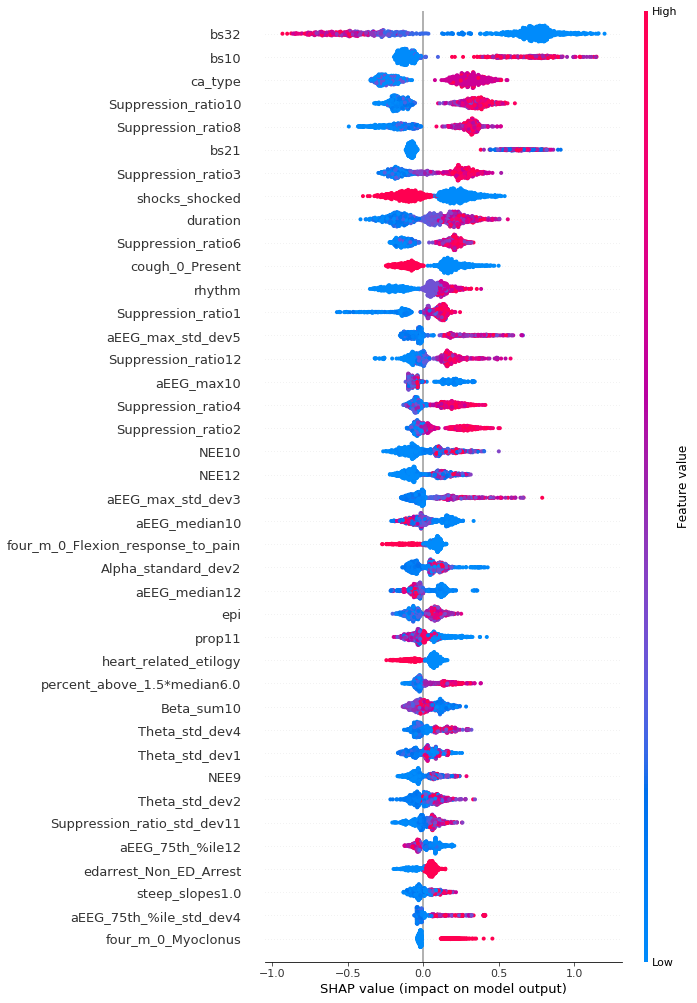

In [431]:
import shap
shap_values=shap.TreeExplainer(xgb).shap_values(combined_data.drop(columns=["outcome","PID"]).astype("float"))
shap.summary_plot(shap_values, combined_data.drop(columns=["outcome","PID"]).astype("float"),max_display=40 )


# LOOCV Testing with the selected model

In [83]:
def model_iterations(model):
    ksm = SMOTE(random_state=42)
    y_pred_list=[]
    loo = LeaveOneOut()
    y_index=[]
    X=combined_data.drop(columns=["PID","outcome"]).values
    Y=combined_data["outcome"].values
    loo.get_n_splits(X)
#     mm=MinMaxScaler()
     
    for train_index, test_index in loo.split(X):
    
        X_train,X_test,Y_train,Y_test=X[train_index],X[test_index],Y[train_index],Y[test_index]
#         X_train,Y_train=ksm.fit_resample(X_train, Y_train)
#         X_train=mm.fit_transform(X_train)
#         X_test=mm.fit_transform(X_test)
        best_model = model
        best_model.fit(X_train, Y_train)
        
        y_pred=best_model.predict_proba(X_test)
        y_pred=(y_pred[:,1]>=0.99).astype('int')
        y_pred_list.append(y_pred[0])
        y_index.append(test_index[0])   
    return y_pred_list,y_index


In [89]:
model=param_list[1]
output=model_iterations(model)

In [90]:
y_pred,y_test_index=output

In [91]:
Y_test=combined_data["outcome"].values
tn, fp, fn, tp=confusion_matrix(Y_test.flatten()[y_test_index], y_pred).ravel()
fpr=fp/(fp+tn)
tpr=tp/(tp+fn)

In [92]:
tpr #51

0.357429718875502

In [93]:
fpr

0.0033333333333333335

In [52]:
y_test_index=np.array(y_test_index)
y_test_index[Y_test.flatten()[y_test_index]!= y_pred]
Y_test.flatten()[Y_test.flatten()[y_test_index]!= y_pred]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,